In [1]:
import sys
sys.path.insert(0, '../src')
import harmoutil

import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit

from keras.models import Model
from keras.layers import Input, Dense, GRU, concatenate

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.models import load_model

import matplotlib.pyplot as plt

/home/maxime/.local/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load data
raw_data = harmoutil.load_pickled_data("../data/refined_data.pkl") # lists of (chord label, melody seqs) by sections
print("---Raw data---")
print("Number of sections: {}".format(len(raw_data)))
print("Sample section: {}\n".format(raw_data[0]))
augmented_data = harmoutil.transpose_and_augment_data(raw_data)
print("---Transpose and augment data---")
print("Number of sections after data augmentation: {}".format(len(augmented_data)))
print("Sample section: {}\n".format(augmented_data[0]))
data = [harmoutil.to_sevenths(section) for section in augmented_data]
print("---Truncate chords to sevenths---")
print("Number of sections: {}".format(len(data)))
print("Sample section: {}\n".format(data[0]))
data = [harmoutil.melody_to_octave_range(section) for section in data]
print("---Convert melody to integers---")
print("Number of sections: {}".format(len(data)))
print("Sample section: {}\n".format(data[0]))

---Raw data---
Number of sections: 2408
Sample section: [('Bb6', [[58.0], [58.0]]), ('G7', [[-1.0], [-1.0]]), ('C-7', [[-1.0], [-1.0]]), ('F7', [[-1.0], [-1.0]]), ('Bb', [[-1.0], [-1.0]]), ('G-7', [[50.0], [57.0, 60.0]]), ('C-7', [[58.0, 55.0], [58.0]]), ('F7', [[61.0], [60.0, 58.0]]), ('F-7', [[60.0], [58.0]]), ('Bb7', [[56.0, 60.0], [59.0, 57.0]]), ('Eb7', [[58.0, 54.0], [55.0, 58.0]]), ('Ab7', [[61.0, 56.0], [61.0, 62.0]]), ('D-7', [[58.0, 60.0], [55.0, 58.0]]), ('G7', [[58.0], [-1.0]]), ('C-7', [[-1.0], [-1.0]]), ('F7', [[-1.0], [-1.0]])]

---Transpose and augment data---
Number of sections after data augmentation: 28884
Sample section: [('E6', [[52.0], [52.0]]), ('Db7', [[-1.0], [-1.0]]), ('Gb-7', [[-1.0], [-1.0]]), ('B7', [[-1.0], [-1.0]]), ('E', [[-1.0], [-1.0]]), ('Db-7', [[44.0], [51.0, 54.0]]), ('Gb-7', [[52.0, 49.0], [52.0]]), ('B7', [[55.0], [54.0, 52.0]]), ('B-7', [[54.0], [52.0]]), ('E7', [[50.0, 54.0], [53.0, 51.0]]), ('A7', [[52.0, 48.0], [49.0, 52.0]]), ('D7', [[55.0, 

In [3]:
# Create individual chord and melody element lists 
def get_notes_by_chord(beats):
    return [note for beat in beats for note in beat]

def get_chords_by_section(section):
    return [chord_info[0] for chord_info in section]

def check_if_augmented_major(section):
    section_chords = get_chords_by_section(section)
    for ch in section_chords:
        if "+j7" in ch:
            return True
    return False


# Remove sections that involve augmented major chords (since not enough data to even allow StratifiedShuffleSplit)
data = [section for section in data if not check_if_augmented_major(section)]
print("---Remove sections with augmented major chord---")
print("Number of sections: {}\n".format(len(data)))

chords_by_sections = [get_chords_by_section(section) for section in data]
chords = [chord_info[0] for section in data for chord_info in section]
notes_by_chords = [get_notes_by_chord(chord_info[1]) for section in data for chord_info in section]
notes = [note for chord_notes in notes_by_chords for note in chord_notes]
# print(sum([len(section) for section in chords_by_sections]))
print("Number of sections: {} | Sample section chords: {}".format(len(chords_by_sections), chords_by_sections[0]))
print("Number of chords: {} | Sample chord: {}".format(len(chords), chords[0]))
print("Number of melodies {} | Sample melody: {}".format(len(notes_by_chords), notes_by_chords[0]))
print("Number of melody notes in the data: {} | Sample melody note: {}".format(len(notes), notes[0]))

---Remove sections with augmented major chord---
Number of sections: 28836

Number of sections: 28836 | Sample section chords: ['E6', 'Db7', 'Gb-7', 'B7', 'E', 'Db-7', 'Gb-7', 'B7', 'B-7', 'E7', 'A7', 'D7', 'Ab-7', 'Db7', 'Gb-7', 'B7']
Number of chords: 333480 | Sample chord: E6
Number of melodies 333480 | Sample melody: [4, 4]
Number of melody notes in the data: 2195328 | Sample melody note: 4


In [4]:
# Create categorical data mappings

# Note to integer index
note_to_int = dict([(c, i) for i, c in enumerate(sorted(list(set(notes)))[1:])])
note_to_int[-1] = len(note_to_int)
note_to_int['<pad>'] = len(note_to_int)
print("Melody note to integer mapping:\n {}\n".format(note_to_int))

# Integer to note
int_to_note = dict([(k, v) for v, k in note_to_int.items()])
print("Integer to melody note mapping:\n {}\n".format(int_to_note))

# Chord to integer index
chord_to_int = dict([(c, i) for i, c in enumerate(sorted(list(set(chords))))])
chord_to_int['<bos>'] = len(chord_to_int)
print("Chord label to integer mapping:\n {}\n".format(chord_to_int))


# Integer to chord index
int_to_chord = dict([(k, v) for v, k in chord_to_int.items()])
print("Integer to chord label mapping:\n {}\n".format(int_to_chord))

Melody note to integer mapping:
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, -1: 12, '<pad>': 13}

Integer to melody note mapping:
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: -1, 13: '<pad>'}

Chord label to integer mapping:
 {'Ebo': 125, 'Dsus': 103, 'A+': 1, 'Eb-6': 118, 'Bm7b5': 55, 'Absus7': 23, 'Am7b5': 25, 'Gb-6': 163, 'B': 30, 'Bbo7': 51, 'Bo': 56, 'G+': 151, 'D': 75, 'Csus': 73, 'D-7': 80, 'Db-6': 88, 'Bsus7': 59, 'F-7': 140, 'Dj7': 99, 'Gsus': 178, 'E-6': 109, 'Bo7': 57, 'D-6': 79, 'Ao': 26, 'Eb': 114, 'Bb-j7': 45, 'Cj7': 69, 'Eb+7': 116, 'Dbo7': 96, 'Bb+7': 41, 'Db+': 85, 'Bsus': 58, 'G-j7': 156, 'Bj7': 54, 'C-': 63, 'G-6': 154, 'Csus7': 74, 'Dsus7': 104, 'Bb7': 47, 'Ej7': 129, 'Bbj7': 48, 'Gbsus7': 173, 'Dbj7': 93, 'Ebo7': 126, 'A-j7': 6, 'Esus7': 134, 'B-': 33, 'Eb-7': 119, 'Dm7b5': 100, 'F-': 138, 'F7': 143, 'Eb6': 121, 'Eo7': 132, 'Db-j7': 90, 'Ab+7': 11, 'Co7': 72, 'C-6': 64, 'Fo7': 147, 'Ab6': 16, 'C

In [5]:
# Define numerical variables

n_samples = len(chords)
n_notes = len(note_to_int)
n_chords = len(chord_to_int)
n_pitches = 12
max_melody_len = max([len(mel_seq) for mel_seq in notes_by_chords])
chord_context_len = 7

print("Total number of samples: {}".format(n_samples))
print("Number of distinct melody notes: {}".format(n_notes))
print("Number of distinct chord labels: {}".format(n_chords))
print("Number of distinct chord pitches: {}".format(n_pitches))
print("Maximum melody sequence length: {}".format(max_melody_len))
print("Fixed context chord sequence length: {}".format(7))

Total number of samples: 333480
Number of distinct melody notes: 14
Number of distinct chord labels: 182
Number of distinct chord pitches: 12
Maximum melody sequence length: 135
Fixed context chord sequence length: 7


In [6]:
# Prepare tensor data

def pad_melody(melody, max_len):
    return melody + (max_len-len(melody))*['<pad>']

def build_input_chord_sequences(chord_seq, context_len):
    padded_sequence = context_len*['<bos>'] + chord_seq
    formatted_sequences = [padded_sequence[i:i+context_len+1] for i in range(len(chord_seq))]
    return formatted_sequences

# Melody
input_melody_data = [pad_melody(melody, max_melody_len) for melody in notes_by_chords]
print("Sample input melody sequence: {}\n".format(input_melody_data[5]))


# Chords
formatted_chords_data = []
for section_chords in chords_by_sections:
    formatted_chords_data += build_input_chord_sequences(section_chords, chord_context_len)

input_chords_data = [ch[:-1] for ch in formatted_chords_data]
target_chords_data = [ch[-1] for ch in formatted_chords_data]
print("Sample input chord sequence: {}\n".format(input_chords_data[5]))
print("Sample target chord: {}\n".format(target_chords_data[5]))

print("Input melody: {}, Input chords: {}, Target chords: {}".format(len(input_melody_data), len(input_chords_data), len(target_chords_data)))

Sample input melody sequence: [8, 3, 6, '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>

In [7]:
# Build tensors

X_melody = np.zeros((n_samples, max_melody_len, n_notes), dtype='float32')
X_chords = np.zeros((n_samples, chord_context_len, n_pitches), dtype='float32')
Y = np.zeros((n_samples, n_pitches), dtype='float32')
Y_labels = np.zeros((n_samples, n_chords), dtype='float32')

for i, (input_mel, input_ch, target_ch) in enumerate(zip(input_melody_data, input_chords_data, target_chords_data)):
    
    Y_labels[i, chord_to_int[target_ch]] = 1 # tensor of chords one-hot vectors used for dataset splitting
    
    target_chord_pitches = [0]*12 if target_ch == '<bos>' else harmoutil.chord_to_notes(target_ch)
    for j, pitch_presence in enumerate(target_chord_pitches):
        Y[i, j] = pitch_presence

    for j, chord in enumerate(input_ch):
        input_chord_pitches = [0]*12 if chord == '<bos>' else harmoutil.chord_to_notes(chord)
        for k, pitch_presence in enumerate(input_chord_pitches):
            X_chords[i, j, k] = pitch_presence


In [8]:
# Split dataset into 80%-10%-10% train-valid-test

seed = 0

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

for train_index, aux_index in sss.split(X_chords, Y_labels):
    X_melody_train, X_melody_aux = X_melody[train_index], X_melody[aux_index]
    X_chords_train, X_chords_aux = X_chords[train_index], X_chords[aux_index]
    Y_train, Y_aux = Y[train_index], Y[aux_index]
    Y_labels_train, Y_labels_aux = Y_labels[train_index], Y_labels[aux_index]
    
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)

for valid_index, test_index in sss.split(X_chords_aux, Y_labels_aux):
    X_melody_valid, X_melody_test = X_melody[valid_index], X_melody[test_index]
    X_chords_valid, X_chords_test = X_chords[valid_index], X_chords[test_index]
    Y_valid, Y_test = Y[valid_index], Y[test_index]
    Y_labels_valid, Y_labels_test = Y_labels[valid_index], Y_labels[test_index]

In [10]:
# Define neural net architecture

latent_dim = 128

melody_input = Input(shape=(max_melody_len, n_notes))
melody_gru = GRU(latent_dim)(melody_input)

chords_input = Input(shape=(chord_context_len, n_pitches))
chords_gru = GRU(latent_dim)(chords_input)

concat = concatenate([melody_gru, chords_gru])

chord_dense = Dense(n_pitches, activation='sigmoid')(concat)

model = Model([melody_input, chords_input], chord_dense)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())
# SVG(model_to_dot(model).create(prog='dot', format='svg'))


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 135, 14)       0                                            
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, 7, 12)         0                                            
____________________________________________________________________________________________________
gru_3 (GRU)                      (None, 128)           54912       input_3[0][0]                    
____________________________________________________________________________________________________
gru_4 (GRU)                      (None, 128)           54144       input_4[0][0]                    
___________________________________________________________________________________________

In [11]:
# Introduce Early-Stopping and Save-Best-Performance callbacks
filepath = "../models/pitch-Mel1-Cho1-FC1_150ep_32bat.h5"
bp = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [12]:
# Train model
batch_size = 32
epochs = 150

history = model.fit([X_melody_train, X_chords_train], Y_train, epochs=epochs, validation_data=([X_melody_valid, X_chords_valid], Y_valid,), batch_size=batch_size, callbacks=[bp])

Train on 266784 samples, validate on 33348 samples
Epoch 1/150
266784/266784 [==============================] - 898s - loss: 0.5207 - acc: 0.7504 - val_loss: 0.4777 - val_acc: 0.7808
Epoch 2/150
266784/266784 [==============================] - 891s - loss: 0.4623 - acc: 0.7883 - val_loss: 0.4494 - val_acc: 0.7964
Epoch 3/150
266784/266784 [==============================] - 891s - loss: 0.4340 - acc: 0.8047 - val_loss: 0.4315 - val_acc: 0.8069
Epoch 4/150
266784/266784 [==============================] - 891s - loss: 0.4151 - acc: 0.8153 - val_loss: 0.4210 - val_acc: 0.8129
Epoch 5/150
266784/266784 [==============================] - 889s - loss: 0.4020 - acc: 0.8219 - val_loss: 0.4160 - val_acc: 0.8168
Epoch 6/150
266784/266784 [==============================] - 890s - loss: 0.3924 - acc: 0.8268 - val_loss: 0.4119 - val_acc: 0.8170
Epoch 7/150
266784/266784 [==============================] - 891s - loss: 0.3850 - acc: 0.8306 - val_loss: 0.4086 - val_acc: 0.8210
Epoch 8/150
266784/266784

266784/266784 [==============================] - 886s - loss: 0.3486 - acc: 0.8484 - val_loss: 0.3935 - val_acc: 0.8306
Epoch 27/150
266784/266784 [==============================] - 895s - loss: 0.3479 - acc: 0.8487 - val_loss: 0.3932 - val_acc: 0.8300
Epoch 28/150
266784/266784 [==============================] - 895s - loss: 0.3475 - acc: 0.8490 - val_loss: 0.3931 - val_acc: 0.8306
Epoch 29/150
266784/266784 [==============================] - 895s - loss: 0.3470 - acc: 0.8491 - val_loss: 0.3926 - val_acc: 0.8318
Epoch 30/150
266784/266784 [==============================] - 895s - loss: 0.3463 - acc: 0.8494 - val_loss: 0.3933 - val_acc: 0.8313
Epoch 31/150
266784/266784 [==============================] - 896s - loss: 0.3461 - acc: 0.8497 - val_loss: 0.3913 - val_acc: 0.8312
Epoch 32/150
266784/266784 [==============================] - 894s - loss: 0.3456 - acc: 0.8499 - val_loss: 0.3923 - val_acc: 0.8312
Epoch 33/150
266784/266784 [==============================] - 892s - loss: 0.3449 

266784/266784 [==============================] - 892s - loss: 0.3392 - acc: 0.8526 - val_loss: 0.3879 - val_acc: 0.8327
Epoch 57/150
266784/266784 [==============================] - 897s - loss: 0.3390 - acc: 0.8527 - val_loss: 0.3885 - val_acc: 0.8342
Epoch 58/150
266784/266784 [==============================] - 898s - loss: 0.3389 - acc: 0.8528 - val_loss: 0.3880 - val_acc: 0.8328
Epoch 59/150
266784/266784 [==============================] - 896s - loss: 0.3387 - acc: 0.8528 - val_loss: 0.3860 - val_acc: 0.8344
Epoch 60/150
266784/266784 [==============================] - 894s - loss: 0.3385 - acc: 0.8531 - val_loss: 0.3870 - val_acc: 0.8349
Epoch 61/150
266784/266784 [==============================] - 896s - loss: 0.3385 - acc: 0.8532 - val_loss: 0.3847 - val_acc: 0.8346
Epoch 62/150
266784/266784 [==============================] - 896s - loss: 0.3382 - acc: 0.8533 - val_loss: 0.3867 - val_acc: 0.8340
Epoch 63/150
266784/266784 [==============================] - 896s - loss: 0.3381 

266784/266784 [==============================] - 887s - loss: 0.3356 - acc: 0.8543 - val_loss: 0.3888 - val_acc: 0.8344
Epoch 88/150
266784/266784 [==============================] - 890s - loss: 0.3353 - acc: 0.8544 - val_loss: 0.3866 - val_acc: 0.8342
Epoch 89/150
266784/266784 [==============================] - 887s - loss: 0.3354 - acc: 0.8542 - val_loss: 0.3854 - val_acc: 0.8355
Epoch 90/150
266784/266784 [==============================] - 891s - loss: 0.3351 - acc: 0.8544 - val_loss: 0.3873 - val_acc: 0.8342
Epoch 91/150
266784/266784 [==============================] - 891s - loss: 0.3353 - acc: 0.8544 - val_loss: 0.3852 - val_acc: 0.8353
Epoch 92/150
266784/266784 [==============================] - 890s - loss: 0.3351 - acc: 0.8548 - val_loss: 0.3868 - val_acc: 0.8348
Epoch 93/150
266784/266784 [==============================] - 889s - loss: 0.3350 - acc: 0.8545 - val_loss: 0.3862 - val_acc: 0.8346
Epoch 94/150
266784/266784 [==============================] - 888s - loss: 0.3350 

266784/266784 [==============================] - 887s - loss: 0.3337 - acc: 0.8550 - val_loss: 0.3839 - val_acc: 0.8366
Epoch 119/150
266784/266784 [==============================] - 894s - loss: 0.3335 - acc: 0.8553 - val_loss: 0.3838 - val_acc: 0.8359
Epoch 120/150
266784/266784 [==============================] - 893s - loss: 0.3337 - acc: 0.8551 - val_loss: 0.3844 - val_acc: 0.8361
Epoch 121/150
266784/266784 [==============================] - 893s - loss: 0.3333 - acc: 0.8553 - val_loss: 0.3868 - val_acc: 0.8345
Epoch 122/150
266784/266784 [==============================] - 891s - loss: 0.3333 - acc: 0.8552 - val_loss: 0.3863 - val_acc: 0.8354
Epoch 123/150
266784/266784 [==============================] - 893s - loss: 0.3334 - acc: 0.8551 - val_loss: 0.3839 - val_acc: 0.8365
Epoch 124/150
266784/266784 [==============================] - 894s - loss: 0.3335 - acc: 0.8552 - val_loss: 0.3860 - val_acc: 0.8360
Epoch 125/150
266784/266784 [==============================] - 895s - loss: 

266784/266784 [==============================] - 893s - loss: 0.3325 - acc: 0.8556 - val_loss: 0.3840 - val_acc: 0.8364
Epoch 150/150
266784/266784 [==============================] - 894s - loss: 0.3328 - acc: 0.8553 - val_loss: 0.3857 - val_acc: 0.8353


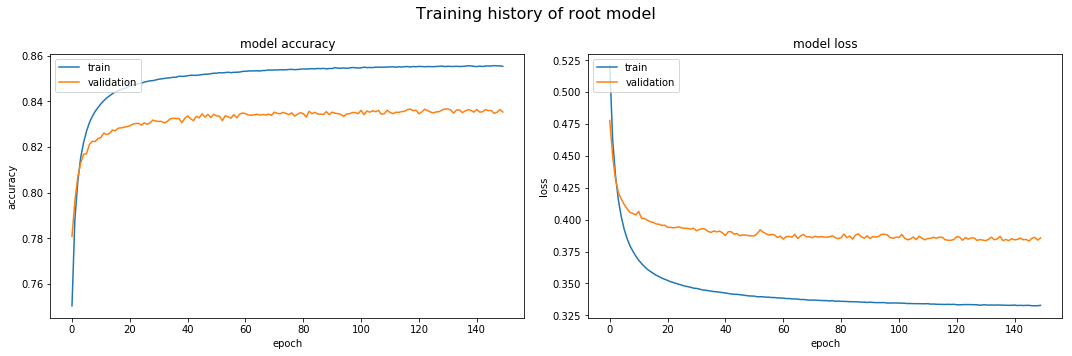

In [13]:
# Visualize model learning
plt.clf()

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.show()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()
plt.suptitle("Training history of root model", fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

In [14]:
### Load best performance model ###
model = load_model("../models/pitch-Mel1-Cho1-FC1_150ep_32bat.h5")

In [15]:
# Evaluate predictions in terms of labels

# Predict chords from each test sample melody
Y_pred = model.predict([X_melody_test, X_chords_test])

# Compute accuracy and kappa score
print("Categorical accuracy of combined chord prediction: {0:.4f}".format(harmoutil.compute_multiclass_binary_accuracy_score(Y_test, Y_pred)))
print("Kappa score of combined chord prediction: {0:.4f}".format(harmoutil.compute_multiclass_binary_kappa_score(Y_test, Y_pred)))

Categorical accuracy of combined chord prediction: 0.8325
TP: 85211 TN: 247948 FP: 22102 FN: 44915
Kappa score of combined chord prediction: 0.6003
